In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!ls

combined_data_1.txt  netflix.ipynb


#### **Formatting the data**

In [3]:
fopen = open('combined_data_1.txt', 'r')
fwrite = open('data.txt', 'a+')
fopen.seek(0)
fwrite.seek(0)
fwrite.writelines('CustomerID,Score,Date,MovieID\n')

for line in fopen.readlines():
    line = line.strip()
    if line[-1] == ':':
        movie_id = line[:-1]
    else:
        fwrite.writelines(line + ',' + movie_id + '\n')

fopen.close()
fwrite.close()

#### **Exploring the data**

In [4]:
data = pd.read_csv('data_large.csv')
data.head()

,CustomerID,Score,Date,MovieID
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


In [6]:
print(data.CustomerID.nunique())
print(data.MovieID.nunique())
print(data.shape)

470758
4499
(24053764, 4)


In [7]:
data.Score.value_counts()

4    8085741
3    6904181
5    5506583
2    2439073
1    1118186
Name: Score, dtype: int64

In [8]:
data = data[['CustomerID', 'MovieID', 'Score']].copy()
data.columns = ['user', 'item', 'rating']
data

,user,item,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
...,...,...,...
24053759,2591364,4499,2
24053760,1791000,4499,2
24053761,512536,4499,5
24053762,988963,4499,3


In [9]:
data.drop_duplicates(inplace = True)
data
# seems no duplicates in data

,user,item,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
...,...,...,...
24053759,2591364,4499,2
24053760,1791000,4499,2
24053761,512536,4499,5
24053762,988963,4499,3


In [10]:
data_all = data[['user', 'item']].copy()
data_all.drop_duplicates(inplace = True)
data_all

,user,item
0,1488844,1
1,822109,1
2,885013,1
3,30878,1
4,823519,1
...,...,...
24053759,2591364,4499
24053760,1791000,4499
24053761,512536,4499
24053762,988963,4499


In [11]:
data45 = data[data.rating >= 4]
data45 = data45[['user', 'item']].copy()
data45

,user,item
1,822109,1
2,885013,1
3,30878,1
6,124105,1
8,1842128,1
...,...,...
24053750,2092745,4499
24053751,555962,4499
24053754,272857,4499
24053758,2562830,4499


In [12]:
# For the time being, I'll work with only 4 and 5 star ratings
data45.to_csv('high_ratings.csv', index = False)

In [14]:
os.path.getsize('high_ratings.csv') >> 20
# size of the file high_ratings.csv is 160 MB 

160

#### **Explore the clean data**

In [53]:
data = pd.read_csv('high_ratings.csv')
data

,user,item
0,822109,1
1,885013,1
2,30878,1
3,124105,1
4,1842128,1
...,...,...
13592319,2092745,4499
13592320,555962,4499
13592321,272857,4499
13592322,2562830,4499


In [54]:
print(data.user.nunique())
print(data.item.nunique())
print(data.shape)

458436
4498
(13592324, 2)


In [23]:
item_degrees = data.item.value_counts()
item_degrees_50 = item_degrees[item_degrees >= 100]
print('# movies watched atleast 50 times: ', len(item_degrees_50))

# movies watched atleast 50 times:  2935


In [24]:
user_degrees = data.user.value_counts()
user_degrees_50 = user_degrees[user_degrees >= 100]
print('# users who watched atleast 50 movies: ', len(user_degrees_50))

# users who watched atleast 50 movies:  26499


#### **Filter the data to increase density of the interaction matrix**

In [55]:
filtered = data.copy()

user_threshold = 150
item_threshold = 150

previous_shape = (-1, -1)
new_shape = filtered.shape
iters = 0

# keep filtering till it converges and satisfies given thresholds
while previous_shape != new_shape:
    filtered = filtered.groupby('item').filter(lambda x: len(x) >= item_threshold)
    filtered = filtered.groupby('user').filter(lambda x: len(x) >= user_threshold)
    previous_shape = new_shape
    new_shape = filtered.shape
    iters += 1

print('Shape of filtered data: ', new_shape)
print('Filtrations required to converge: ', iters)

Shape of filtered data:  (1660495, 2)
Filtrations required to converge:  6


In [56]:
filtered.to_csv('filtered_data_150.csv', index = False)

#### **Explore filtered data**

In [57]:
os.path.getsize('filtered_data_150.csv') >> 20

19

In [62]:
data = pd.read_csv('filtered_data_150.csv')

n_users = data.user.nunique()
n_items = data.item.nunique()
n_samples = data.shape[0]

print('users: ', n_users)
print('items: ', n_items)
print('ratings: ', n_samples)

data

users:  8138
items:  1503
ratings:  1660495


,user,item
0,1488844,8
1,306466,8
2,1174811,8
3,567025,8
4,622194,8
...,...,...
1660490,2513621,4496
1660491,1388741,4496
1660492,2082805,4496
1660493,823628,4496


In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data.user = le.fit_transform(data.user)
data.item = le.fit_transform(data.item)
data

,user,item
0,4573,0
1,896,0
2,3595,0
3,1725,0
4,1900,0
...,...,...
1660490,7702,1502
1660491,4240,1502
1660492,6338,1502
1660493,2507,1502


In [64]:
n_users = data.user.nunique()
n_items = data.item.nunique()
n_samples = data.shape[0]

print('users: ', n_users)
print('items: ', n_items)
print('ratings: ', n_samples)

users:  8138
items:  1503
ratings:  1660495


In [66]:
data.to_csv('data.csv', index = False)

#### **Create adjacency matrix**

In [67]:
data = pd.read_csv('data.csv')
data

,user,item
0,4573,0
1,896,0
2,3595,0
3,1725,0
4,1900,0
...,...,...
1660490,7702,1502
1660491,4240,1502
1660492,6338,1502
1660493,2507,1502


In [68]:
print(data.user.unique())
print(data.item.unique())
print(data.user.unique().max())
print(data.item.unique().max())

[4573  896 3595 ...   69  546 2206]
[   0    1    2 ... 1500 1501 1502]
8137
1502


In [69]:
n_users = data.user.nunique()
n_items = data.item.nunique()
n_samples = data.shape[0]

print('users: ', n_users)
print('items: ', n_items)
print('ratings: ', n_samples)

users:  8138
items:  1503
ratings:  1660495


In [71]:
density = n_samples / (n_users * n_items)
print('Density of interaction matrix: ', density)

Density of interaction matrix:  0.13575658546101046


In [70]:
adj = np.zeros((n_users, n_items), dtype = int)
print(adj.shape)

for _, row in data.iterrows():
    u = row['user']
    i = row['item']
    adj[u][i] = 1

(8138, 1503)


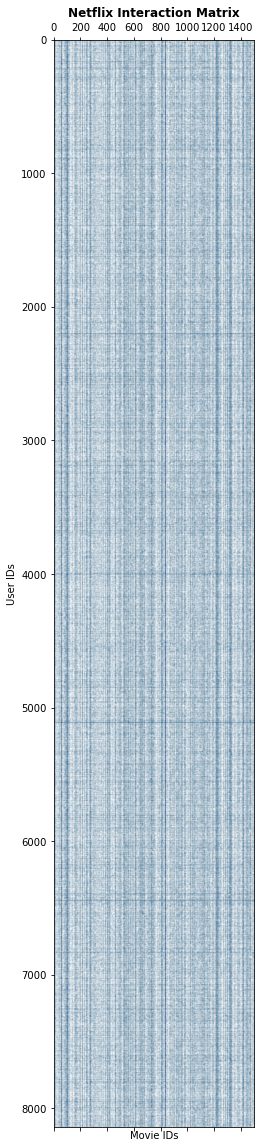

In [83]:
plt.figure(figsize = (20, 20))
plt.spy(adj, markersize=0.004)
plt.xlabel('Movie IDs')
plt.ylabel('User IDs')
plt.title('Netflix Interaction Matrix', fontweight = 'bold')
plt.savefig('interaction-matrix')
plt.show()

In [85]:
user_degrees = adj.sum(axis = 1)
print(user_degrees.shape)
item_degrees = adj.sum(axis = 0)
print(item_degrees.shape)

(8138,)
(1503,)


In [86]:
print('Max movies by a user: ', user_degrees.max())
print('Min movies by a user: ', user_degrees.min())
print('Avg movies by a user: ', round(user_degrees.mean(), 1))

print('Most views for a movie: ', item_degrees.max())
print('Least views for a movie: ', item_degrees.min())
print('Avg views for a movie: ', round(item_degrees.mean(), 1))

Max movies by a user:  1378
Min movies by a user:  150
Avg movies by a user:  204.0
Most views for a movie:  7269
Least views for a movie:  150
Avg views for a movie:  1104.8


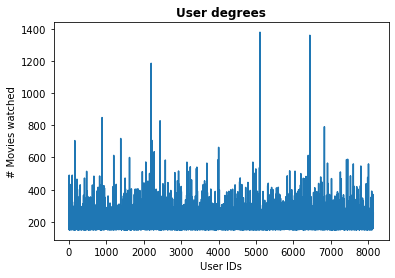

In [87]:
plt.plot(user_degrees)
plt.xlabel('User IDs')
plt.ylabel('# Movies watched')
plt.title('User degrees', fontweight = 'bold')
plt.savefig('user-degrees')
plt.show()

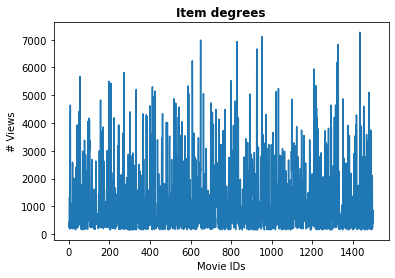

In [88]:
plt.plot(item_degrees)
plt.xlabel('Movie IDs')
plt.ylabel('# Views')
plt.title('Item degrees', fontweight = 'bold')
plt.savefig('item-degrees')
plt.show()